<a href="https://colab.research.google.com/github/ttderessa/Temesgen-Deressa/blob/main/Agent_Based_Epidemic_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⚠️  IMPORTANT: This is a simplified educational model.
   Do not use results for real-world decision making.
   Focus on RELATIVE differences between scenarios, not absolute numbers.

Running scenario A...
Exported results to abm_scenarioA_scenarioA.csv
Running scenario B...
Exported results to abm_scenarioB_scenarioB.csv
Running scenario C...
Exported results to abm_scenarioC_scenarioC.csv


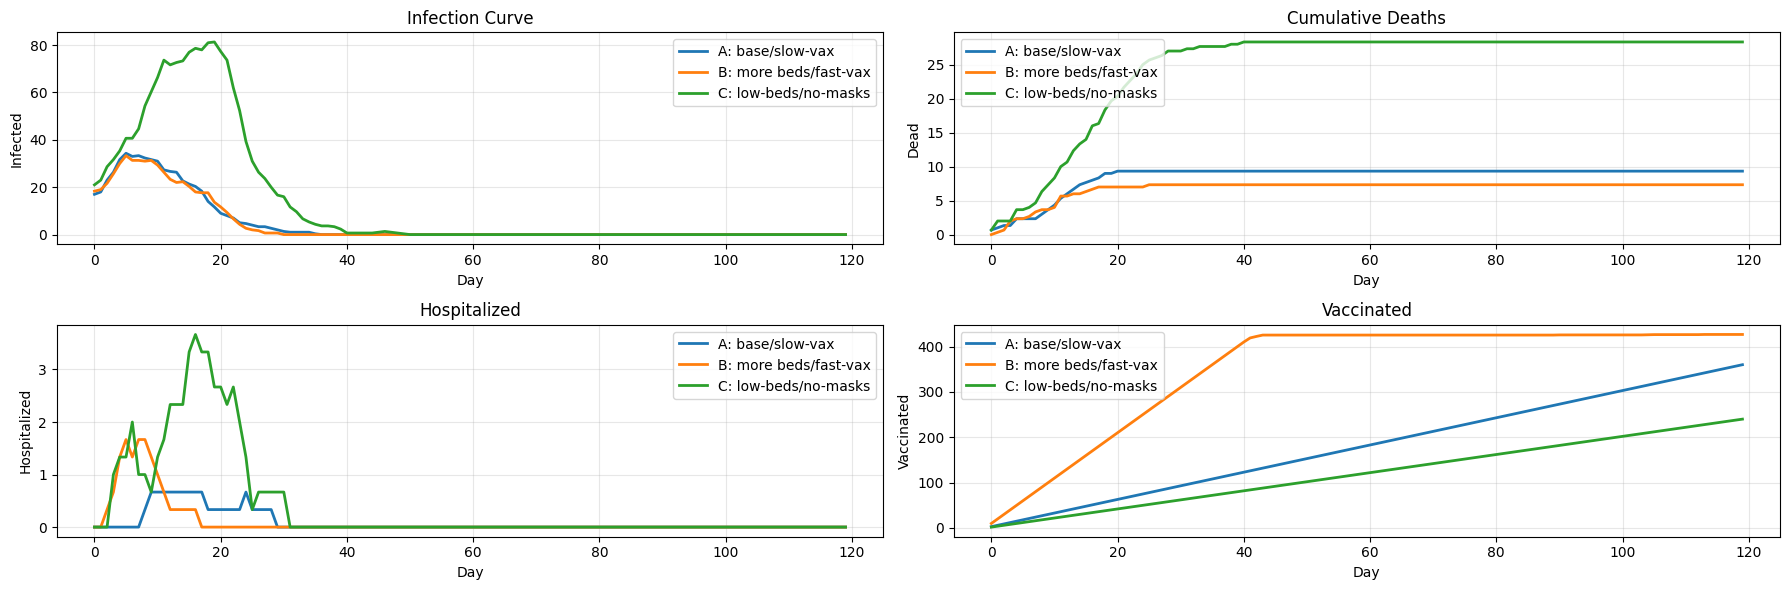


Scenario Comparison Summary:
             Scenario  Total_Deaths_Mean  Total_Deaths_STD  Peak_Infected_Mean  Final_Vaccinated_Mean
     A: base/slow-vax           9.333333          4.041452           36.333333             360.000000
B: more beds/fast-vax           7.333333          3.785939           34.000000             426.666667
 C: low-beds/no-masks          28.333333          6.658328           84.333333             240.000000

REMINDER: This model has significant limitations:
- Does not include economic or social impacts
- Assumes perfect compliance with interventions
- Simplified contact network structure
- Many parameters are estimates with high uncertainty


In [2]:
"""
Research-Grade Agent-Based Epidemic Model (Pure Python)

Features:
- Agents with age groups (Young, Adult, Elderly) and heterogenous parameters
- Contact network (random + household clusters)
- Stochastic infection per contact, illness duration, reinfection due to waning immunity
- Vaccination rollout with prioritization and vaccine efficacy (prevent infection & reduce severity)
- Hospital + ICU with capacity, queues, and staff shortages affecting mortality
- Non-pharmaceutical interventions: lockdown (reduce contacts), masks (reduce transmission)
- Scenario runner supporting multiple replications and CSV export
- Dashboard plotting for comparison

Author: Deressa
"""

import random
import math
import csv
from collections import defaultdict, deque
import statistics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Optional, Tuple, Any

# ---------------------------
# PARAMETERS (tunable)
# ---------------------------
DEFAULT_PARAMS = {
    "n_agents": 500,
    "initial_infected": 15,
    "steps": 150,  # days
    "seed": 42,

    # Network
    "p_random_contact": 0.01,   # probability of random edge between two agents (ER graph)
    "avg_household_size": 3,
    "household_fraction": 0.4,  # fraction of population assigned to households (clusters)

    # Age distribution (weights)
    "age_weights": {"Young": 0.5, "Adult": 0.35, "Elderly": 0.15},

    # Age-specific base parameters (per-day)
    # susceptibility_multiplier adjusts infection_prob per contact
    "age_params": {
        "Young": {"susceptibility": 1.0, "recovery_mean_days": 7, "mortality_base": 0.001},
        "Adult": {"susceptibility": 1.0, "recovery_mean_days": 10, "mortality_base": 0.005},
        "Elderly": {"susceptibility": 0.9, "recovery_mean_days": 14, "mortality_base": 0.05},
    },

    # Transmission & disease natural history
    "base_transmission_prob": 0.05,  # prob of transmission per contact per day (before modifiers)
    "infectious_period_draw": (5, 14),  # uniform min/max days if sampling instead of mean
    "recovery_boost_vaccine": 0.5,   # vaccinated reduce chance of severe outcomes
    "waning_immunity_mean_days": 180,
    "waning_immunity_sd": 30,

    # Hospitalization & severity
    "hospitalization_rate_multiplier": {"Young": 0.2, "Adult": 0.8, "Elderly": 1.5},
    "hospital_capacity": 30,
    "icu_capacity": 8,
    "mortality_if_hospitalized_factor": 0.5,  # reduces mortality if hospitalized
    "mortality_if_no_hospital_factor": 2.5,    # increases mortality if no care

    # Vaccination
    "vax_daily_capacity": 4,    # doses/day
    "vax_priority": ["Elderly", "Adult", "Young"],  # groups vaccinated first
    "vax_efficacy_infection": 0.75,  # reduces chance of infection
    "vax_efficacy_severity": 0.7,    # reduces mortality/hospitalization

    # NPIs
    "mask_effectiveness": 0.4,   # reduces transmission probability multiplicatively
    "lockdown_contact_reduction": 0.5,  # percent reduction in random contacts while lockdown
    "lockdown_start": None,
    "lockdown_end": None,

    # Reinfection
    "allow_reinfection": True,

    # Simulation controls
    "run_replications": 1,
    "export_prefix": "abm_results",
}

# ---------------------------
# Utility functions
# ---------------------------
def set_seed(seed: int) -> None:
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)

def sample_waning_days(mean: float, sd: float) -> int:
    """Sample waning immunity days with positive normal distribution."""
    val = random.gauss(mean, sd)
    return max(30, int(round(val)))

def weighted_random_choice(weights: Dict[str, float]) -> str:
    """Choose a key based on weights."""
    choices = list(weights.keys())
    probs = list(weights.values())
    return random.choices(choices, weights=probs, k=1)[0]

# ---------------------------
# Agent class
# ---------------------------
class Agent:
    def __init__(self, uid: int, age_group: str):
        self.uid = uid
        self.age_group = age_group
        self.state = "S"   # S, E (exposed, optional), I, R, D
        self.days_infected = 0
        self.infectious_days_left = 0
        self.hospitalized = False
        self.in_icu = False
        self.vaccinated = False
        self.vax_day = None
        self.immunity_wane_day = None  # absolute day when immunity wanes
        self.household_id = None

    def infect(self, current_day: int, params: Dict[str, Any]) -> None:
        """Infect agent and set disease progression parameters."""
        if self.state == "S":
            self.state = "I"
            # determine infectious duration: sample around age-specific mean
            mean = params["age_params"][self.age_group]["recovery_mean_days"]
            # simpler: sample symmetric around mean
            dur = max(3, int(random.gauss(mean, mean/4)))
            self.infectious_days_left = dur
            self.days_infected = 0
            # assign waning immunity day for future recovered agents
            waning = sample_waning_days(params["waning_immunity_mean_days"], params["waning_immunity_sd"])
            self.immunity_wane_day = current_day + waning

    def vaccinate(self, current_day: int, params: Dict[str, Any]) -> bool:
        """Vaccinate agent if susceptible. Returns True if successful."""
        if not self.vaccinated and self.state == "S":
            self.vaccinated = True
            self.vax_day = current_day
            # set immunity waning (vaccine immunity as well)
            waning = sample_waning_days(params["waning_immunity_mean_days"], params["waning_immunity_sd"])
            self.immunity_wane_day = current_day + waning
            return True
        return False

    def step_day(self, current_day: int, model: 'ABMModel', params: Dict[str, Any]) -> None:
        """Process per-day progression (recovery, mortality, hospital events)."""
        if self.state == "I":
            # decrement infectious days
            self.days_infected += 1
            self.infectious_days_left = max(0, self.infectious_days_left - 1)

            # Determine hospitalization need probabilistically
            if not self.hospitalized:
                hosp_need = self._check_hospitalization_need(params)
                if hosp_need:
                    model.request_hospitalization(self)

            # Check mortality
            if self._check_mortality(params):
                self.state = "D"
                self.hospitalized = False
                model.remove_from_hospital(self)
                return

            # If infectious period over -> recover
            if self.infectious_days_left <= 0:
                self._recover()
                model.remove_from_hospital(self)

        # handle immunity waning (R -> S) if allowed
        if params["allow_reinfection"] and self.state == "R" and self.immunity_wane_day is not None:
            if current_day >= self.immunity_wane_day:
                self._lose_immunity()

    def _check_hospitalization_need(self, params: Dict[str, Any]) -> bool:
        """Check if agent needs hospitalization."""
        base_hosp_prob = 0.01 * params["hospitalization_rate_multiplier"][self.age_group]
        if self.vaccinated:
            base_hosp_prob *= (1 - params["vax_efficacy_severity"])
        return random.random() < base_hosp_prob

    def _check_mortality(self, params: Dict[str, Any]) -> bool:
        """Check if agent dies today."""
        base_mort = params["age_params"][self.age_group]["mortality_base"]
        if self.vaccinated:
            base_mort *= (1 - params["vax_efficacy_severity"])

        # adjust mortality depending on hospital access
        if self.hospitalized:
            mortality_today = base_mort * params["mortality_if_hospitalized_factor"]
        else:
            mortality_today = base_mort * params["mortality_if_no_hospital_factor"]

        return random.random() < mortality_today

    def _recover(self) -> None:
        """Transition agent to recovered state."""
        self.state = "R"
        self.hospitalized = False
        self.in_icu = False

    def _lose_immunity(self) -> None:
        """Transition agent back to susceptible state."""
        self.state = "S"
        self.vaccinated = False
        self.immunity_wane_day = None

# ---------------------------
# Model class
# ---------------------------
class ABMModel:
    def __init__(self, params: Dict[str, Any]):
        self.params = params
        self.day = 0
        self.agents = []
        self.adj = defaultdict(set)  # adjacency list for contacts
        self.hospital_queue = deque()  # agents waiting for hospital admission
        self.hospitalized_agents = []  # list of agents currently in hospital (for counts)
        self.icu_agents = []
        self.metrics = []  # per-day aggregated metrics
        set_seed(params.get("seed", None))
        self._build_population()
        self._build_network()

    def _build_population(self) -> None:
        """Create agents with age distribution."""
        n = self.params["n_agents"]
        for i in range(n):
            age_group = weighted_random_choice(self.params["age_weights"])
            self.agents.append(Agent(i, age_group))

    def _build_network(self) -> None:
        """Build contact network with households and random connections."""
        n = len(self.agents)
        p = self.params["p_random_contact"]

        # Create household clusters
        self._build_household_network(n)

        # Add random ER edges
        self._build_random_network(n, p)

    def _build_household_network(self, n: int) -> None:
        """Build household clusters."""
        num_household = int((self.params["household_fraction"] * n) / self.params["avg_household_size"])
        idxs = list(range(n))
        random.shuffle(idxs)

        for h_id in range(num_household):
            hs = []
            for _ in range(self.params["avg_household_size"]):
                if idxs:
                    hs.append(idxs.pop())

            # Assign household ID and create fully connected network
            for agent_idx in hs:
                self.agents[agent_idx].household_id = h_id
            self._connect_household_members(hs)

    def _connect_household_members(self, household_members: List[int]) -> None:
        """Fully connect all members of a household."""
        for i, agent1 in enumerate(household_members):
            for agent2 in household_members[i+1:]:
                self.adj[agent1].add(agent2)
                self.adj[agent2].add(agent1)

    def _build_random_network(self, n: int, p: float) -> None:
        """Build random ER network edges."""
        for i in range(n):
            for j in range(i+1, n):
                if random.random() < p:
                    self.adj[i].add(j)
                    self.adj[j].add(i)

    def seed_infection(self) -> None:
        """Infect initial agents."""
        initial = min(self.params["initial_infected"], len(self.agents))
        for i in random.sample(range(len(self.agents)), initial):
            self.agents[i].infect(self.day, self.params)

    def daily_vaccination(self) -> None:
        """Vaccinate agents according to prioritization and daily capacity."""
        doses = self.params["vax_daily_capacity"]
        priority = self.params["vax_priority"]

        candidates = [a for a in self.agents if a.state == "S" and not a.vaccinated]

        for group in priority:
            group_cands = [a for a in candidates if a.age_group == group]
            random.shuffle(group_cands)

            while doses > 0 and group_cands:
                a = group_cands.pop()
                if a.vaccinate(self.day, self.params):
                    candidates.remove(a)
                    doses -= 1

            if doses <= 0:
                break

    def apply_npi_modifiers(self) -> Tuple[float, float]:
        """Compute transmission and contact modifiers based on NPIs."""
        trans_mod = 1.0
        contacts_mod = 1.0

        # masks reduce transmission multiplicatively
        if self.params.get("mask_policy", False):
            trans_mod *= (1.0 - self.params["mask_effectiveness"])

        # lockdown reduces random contact edges by factor
        if (self.params["lockdown_start"] is not None and
            self.params["lockdown_start"] <= self.day <= (self.params["lockdown_end"] or float('inf'))):
            contacts_mod *= (1.0 - self.params["lockdown_contact_reduction"])

        return trans_mod, contacts_mod

    def request_hospitalization(self, agent: Agent) -> None:
        """Request hospitalization for an agent."""
        if agent not in self.hospital_queue and not agent.hospitalized:
            self.hospital_queue.append(agent)

    def remove_from_hospital(self, agent: Agent) -> None:
        """Remove agent from hospital and ICU."""
        if agent in self.hospitalized_agents:
            self.hospitalized_agents.remove(agent)
        if agent in self.icu_agents:
            self.icu_agents.remove(agent)
        # Also remove from queue if present
        if agent in self.hospital_queue:
            self.hospital_queue.remove(agent)

    def _update_hospital_admissions(self) -> None:
        """Update hospital and ICU admissions based on capacity."""
        # Admit to hospital up to capacity
        while (len(self.hospitalized_agents) < self.params["hospital_capacity"] and
               self.hospital_queue):
            agent = self.hospital_queue.popleft()
            if agent.state == "I" and agent not in self.hospitalized_agents:
                self.hospitalized_agents.append(agent)
                agent.hospitalized = True

        # Admit to ICU up to capacity (prioritize elderly)
        while len(self.icu_agents) < self.params["icu_capacity"]:
            candidates = [a for a in self.hospitalized_agents
                         if a.age_group == "Elderly" and not a.in_icu]
            if not candidates:
                break
            agent = random.choice(candidates)
            agent.in_icu = True
            self.icu_agents.append(agent)

    def step(self) -> None:
        """Run one day of simulation."""
        # Vaccination first (can change susceptibility same day)
        self.daily_vaccination()

        trans_mod, contacts_mod = self.apply_npi_modifiers()

        # Infection spread
        self._spread_infection(trans_mod, contacts_mod)

        # Update hospital admissions
        self._update_hospital_admissions()

        # Step each agent's progression (recovery/death)
        for agent in list(self.agents):
            agent.step_day(self.day, self, self.params)

        # Collect daily metrics
        self.metrics.append(self.aggregate_metrics())
        self.day += 1

    def _spread_infection(self, trans_mod: float, contacts_mod: float) -> None:
        """Spread infection through contacts."""
        infected_agents = [a for a in self.agents if a.state == "I"]
        if not infected_agents:
            return

        susceptible_agents = [a for a in self.agents if a.state == "S"]

        for agent in susceptible_agents:
            if self._check_infection(agent, trans_mod, contacts_mod):
                agent.infect(self.day, self.params)

    def _check_infection(self, agent: Agent, trans_mod: float, contacts_mod: float) -> bool:
        """Check if agent gets infected from contacts."""
        neighbors = list(self.adj[agent.uid])

        for nb_idx in neighbors:
            # Apply contact reduction during lockdown
            if contacts_mod < 1.0 and random.random() > contacts_mod:
                continue

            nb_agent = self.agents[nb_idx]
            if nb_agent.state == "I" and self._transmission_occurs(agent, nb_agent, trans_mod):
                return True

        return False

    def _transmission_occurs(self, susceptible: Agent, infected: Agent, trans_mod: float) -> bool:
        """Determine if transmission occurs between two agents."""
        base_p = self.params["base_transmission_prob"]
        age_susc = self.params["age_params"][susceptible.age_group]["susceptibility"]
        p_inf = base_p * age_susc * trans_mod

        # vaccine reduces infection chance
        if susceptible.vaccinated:
            p_inf *= (1 - self.params["vax_efficacy_infection"])

        return random.random() < p_inf

    def aggregate_metrics(self) -> Dict[str, Any]:
        """Collect daily metrics."""
        s = sum(1 for a in self.agents if a.state == "S")
        i = sum(1 for a in self.agents if a.state == "I")
        r = sum(1 for a in self.agents if a.state == "R")
        d = sum(1 for a in self.agents if a.state == "D")
        vac = sum(1 for a in self.agents if a.vaccinated)
        hosp = len(self.hospitalized_agents)
        icu = len(self.icu_agents)

        return {
            "day": self.day,
            "Susceptible": s,
            "Infected": i,
            "Recovered": r,
            "Dead": d,
            "Vaccinated": vac,
            "Hospitalized": hosp,
            "ICU": icu
        }

    def run(self, steps: Optional[int] = None) -> None:
        """Run the simulation for specified steps."""
        if steps is None:
            steps = self.params["steps"]

        self.seed_infection()
        for _ in range(steps):
            self.step()

    def to_dataframe(self) -> pd.DataFrame:
        """Convert metrics to pandas DataFrame."""
        return pd.DataFrame(self.metrics)

# ---------------------------
# Scenario & Replications runner
# ---------------------------
def run_experiment(params: Dict[str, Any], scenario_name: str = "base") -> pd.DataFrame:
    """Run multiple replications of an experiment."""
    runs = params.get("run_replications", 1)
    all_dfs = []

    for rep in range(runs):
        p = params.copy()  # shallow copy
        p["seed"] = p.get("seed", 0) + rep  # vary seed by replication

        model = ABMModel(p)
        model.run()
        df = model.to_dataframe()
        df["replication"] = rep
        df["scenario"] = scenario_name
        all_dfs.append(df)

    combo = pd.concat(all_dfs, ignore_index=True)

    # Export CSV
    csv_name = f"{params.get('export_prefix','abm_results')}_{scenario_name}.csv"
    combo.to_csv(csv_name, index=False)
    print(f"Exported results to {csv_name}")

    return combo

# ---------------------------
# Plotting helpers
# ---------------------------
def plot_dashboard(df_list: List[pd.DataFrame], titles: List[str], figsize: Tuple[int, int] = (18, 6)) -> None:
    """Plot comparison dashboard of multiple scenarios."""
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.ravel()

    metrics = [
        ("Infected", "Infection Curve"),
        ("Dead", "Cumulative Deaths"),
        ("Hospitalized", "Hospitalized"),
        ("Vaccinated", "Vaccinated")
    ]

    for idx, (metric, title) in enumerate(metrics):
        for df, t in zip(df_list, titles):
            if "replication" in df.columns:
                df_plot = df.groupby("day").agg({metric: "mean"}).reset_index()
            else:
                df_plot = df
            axes[idx].plot(df_plot["day"], df_plot[metric], label=t, linewidth=2)

        axes[idx].set_title(title)
        axes[idx].set_xlabel("Day")
        axes[idx].set_ylabel(metric)
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_aggregate_comparison(df_list: List[pd.DataFrame], titles: List[str]) -> None:
    """Plot aggregate statistics comparison across scenarios."""
    final_stats = []
    for df, title in zip(df_list, titles):
        if "replication" in df.columns:
            # Get final day statistics for each replication
            final_df = df.groupby("replication").last().reset_index()
            stats = {
                "Scenario": title,
                "Total_Deaths_Mean": final_df["Dead"].mean(),
                "Total_Deaths_STD": final_df["Dead"].std(),
                "Peak_Infected_Mean": df.groupby("replication")["Infected"].max().mean(),
                "Final_Vaccinated_Mean": final_df["Vaccinated"].mean(),
            }
        else:
            stats = {
                "Scenario": title,
                "Total_Deaths": df["Dead"].iloc[-1],
                "Peak_Infected": df["Infected"].max(),
                "Final_Vaccinated": df["Vaccinated"].iloc[-1],
            }
        final_stats.append(stats)

    stats_df = pd.DataFrame(final_stats)
    print("\nScenario Comparison Summary:")
    print("=" * 50)
    print(stats_df.to_string(index=False))

# ---------------------------
# Example scenarios (runner)
# ---------------------------
if __name__ == "__main__":
    print("⚠️  IMPORTANT: This is a simplified educational model.")
    print("   Do not use results for real-world decision making.")
    print("   Focus on RELATIVE differences between scenarios, not absolute numbers.\n")

    # Setup parameter sets for scenarios
    base = DEFAULT_PARAMS.copy()
    base.update({
        "seed": 123,
        "steps": 120,
        "run_replications": 3,
        "vax_daily_capacity": 3,
        "vax_priority": ["Elderly", "Adult", "Young"],
        "mask_policy": True,
        "lockdown_start": 20,
        "lockdown_end": 40,
    })

    # Scenario A: baseline hospital capacity, slow vaccination
    sA = base.copy()
    sA.update({
        "hospital_capacity": 30,
        "vax_daily_capacity": 3,
        "export_prefix": "abm_scenarioA",
    })

    # Scenario B: expanded hospital & faster vaccination
    sB = base.copy()
    sB.update({
        "hospital_capacity": 80,
        "vax_daily_capacity": 10,
        "export_prefix": "abm_scenarioB",
    })

    # Scenario C: overwhelmed hospitals (low capacity), no masks
    sC = base.copy()
    sC.update({
        "hospital_capacity": 10,
        "vax_daily_capacity": 2,
        "mask_policy": False,
        "export_prefix": "abm_scenarioC",
    })

    # Run experiments
    print("Running scenario A...")
    dfA = run_experiment(sA, "scenarioA")

    print("Running scenario B...")
    dfB = run_experiment(sB, "scenarioB")

    print("Running scenario C...")
    dfC = run_experiment(sC, "scenarioC")

    # Plot results
    plot_dashboard([dfA, dfB, dfC], ["A: base/slow-vax", "B: more beds/fast-vax", "C: low-beds/no-masks"])
    plot_aggregate_comparison([dfA, dfB, dfC], ["A: base/slow-vax", "B: more beds/fast-vax", "C: low-beds/no-masks"])

    print("\n" + "="*60)
    print("REMINDER: This model has significant limitations:")
    print("- Does not include economic or social impacts")
    print("- Assumes perfect compliance with interventions")
    print("- Simplified contact network structure")
    print("- Many parameters are estimates with high uncertainty")
    print("="*60)